# Full model String

In [1]:
# Complete Antimony Model definition for the NDS model
NED_string = f"""
        ## Utility functions

        function Hp(Vm,S,hM,h) 
            Vm*((pow(S/hM,h))/(1+pow(S/hM,h))) 
        end
        
        function Hc(Vm,A,R,Q,Ka,ha,Kr,hr,Kq,hq) 
            Vm*((pow(A/Ka,ha))/(1+pow(A/Ka,ha)+pow(R/Kr,hr)+pow(Q/Kq,hq))) 
        end
        
        function Hn(bp,S,hM,h)
            bp/(1+pow(S/hM,h))
        end
        
        function Ma(S,Kd)
            S*Kd
        end

        function MM(S,vmax,Km)
            vmax*S/(Km+S)
        end
        
        model NDS()
        
        # Timescale 1 tick= 1', in CC3D each MCS runs the SBML for 10 tiks= 10'               
        
        # To PS:
        h1_auto = 1.0; # 0.0 for no  H1 autoregulation, 1.0 for H1 autoregulation
        ps_bd4 = 0.0;
        ps_bn1 = 0.0;
        ps_bJ1 = 0.0;
        ps_ind = 0.0;
        ps_ja = 0.0;
        ps_ni = 2000;
        ps_Kdni = 0.0; 
        ps_kconv = 0.0;
        cr = 0;
        ps_K_nui = 0.0;
        
        ## NICD Production Degradation
        Vmni= 100; hMni:= ps_ni; Kdni:= ps_Kdni; tmDN=0; NICD = 0;
        NI_prod: => NICD; Hp(Vmni,(tmDN+cmDN),hMni,4); 
        NI_deg: NICD => ; Ma(NICD,Kdni);
        
        ## Ligands/receptors production and degradation
        Amp=10 # amplification mRNA=>Protein     

        # NOTCH1 expression, can be modifed to include HES1 inducibility
        N1=0; VmN1= Amp*1; hMn1=50; Kdn1=0.05; bN1:= Amp*ps_bn1; sc=25; #bN * scaling 25/min

                                   # N1 inducibility by HES1
        N1_prod: => N1; sc*(bN1);  # + Hp(VmN1,H1,hMn1,4)); 
        N1_deg: N1=> ; Ma(N1,Kdn1)+(tmDN*Hp(Kdn1,(tmDN+cmDN),hMni,4));;
        
        # DLL4 expression repressed by HES1
        D4=0; VmD4= Amp*1; hMd4=50; Kdd4=0.05; bD4:= Amp*ps_bd4; dD4=0;
        
        D4_prod: =>D4; sc*Hn(bD4,H1,hMd4,4); 
        D4_deg: D4=> ; Ma(D4+(dD4*D4/(1+D4)),Kdd4); 
          
        # Jagged1 expression basal and inducible by HES1
        J1=0; VmJ1:= Amp*ps_ind; hMj1:= ps_ja; Kdj1= 0.05; dJ1= 0; bJ1:= Amp*ps_bJ1;
        
        J1_prod: =>J1; sc*(bJ1+Hp(VmJ1,H1,hMj1,4)); 
        J1_deg: J1=> ; Ma(J1+(J1*dJ1/(1+J1)),Kdj1);
        
        ## Transcription Factors expression
        # h1_auto 0.0 for no autoregulation, 1.0 for autoregulation
        
        # HES 1 Autoregulation with delay 
        Kni = 0.5; Khe =0.5; 
        kdel = 0.55; kmm = 0.55; hh1 = 8; Mdh = 0.05;
        vm_prna = 1.4; kdh = 0.35;
        
        pmRNA_prod:  => pmRNA; h1_auto * Hc(vm_prna,(NICD*0.01),HES,pmRNA,Kni,1,Khe,hh1,Kni,1); # Competitive hill function for inactive mRNA production
        mRNA_prod: pmRNA => mRNA; h1_auto * MM(pmRNA,kdel,kmm); # Michaelis-Menten for active mRNA production
        pH1_prod: mRNA => pHES; h1_auto * MM(mRNA,kdel,kmm); # Michaelis-Menten for inactive protein production
        HES_prod: pHES => HES; h1_auto * MM(pHES,kdel,kmm); # Michaelis-Menten for active protein production
        HES_deg: HES => ; h1_auto * MM(HES,kdh,Mdh); # Michaelis-Menten for protein degradation

        # Hes scaling
        # H1 = 0
        H1_scaling: => H1; h1_auto * (HES * 100 - H1);
        
        # HES 1 Without autoregulatory feedback
        hMh1=35; 
        Kdh1 = 0.09; bH1 = 0.0; VmH1 = 10;
        H1_prod: =>H1; (1.0 - h1_auto) * (bH1 + Hp(VmH1,NICD,hMh1,2)); 
        H1_deg: H1=> ; (1.0 - h1_auto) * Ma(H1,Kdh1);

        ## Cis ligand-receptor interactions
        cDNi:= piecewise(D4, D4<N1, N1); # Chose the minimum of D4 and N1    
        cJNi:= piecewise(J1, J1<N1, N1); # Chose the minimum of J1 and N1
        
        # Relative proportion of cis interactions after trans interactions scaled by cr
        crd:=cr*(1-(tmDN/(300+tmDN))); 
        kcd= 0.10; # Degradation rate of cis complexes
        kconv:= ps_kconv; # Conversion rate of cDN complex to transcriptionally active cmDN

        cDN_complex_prod: D4+N1 => cDN;  Ma(cDNi,crd); 
        cmDN_prod_deg: cDN => cmDN; Ma(cDN,kconv) - 0.05 * cmDN;
        cDN_deg: cDN => ; Ma(cDN,kcd);
        
        cJN_complex_prod: J1+N1 => cJN; Ma(cJNi,crd);  
        cJN_deg: cJN => ; Ma(cJN,kcd);

        end
        """

# Load the NED model and check the model string components

In [1]:
from NED_HES_Antimony import NED_runner
runner = NED_runner()
runner.list_model_components()
runner.display_component("utility_functions")

Model components:
HES_auto
HES_no_auto
NED
NICD_reg
cis_interactions
ligands_receptors_reg
model_specs
utility_functions
-------------------

        ## Utility functions

        function Hp(Vm,S,hM,h) 
            Vm*((pow(S/hM,h))/(1+pow(S/hM,h))) 
        end
        
        function Hc(Vm,A,R,Q,Ka,ha,Kr,hr,Kq,hq) 
            Vm*((pow(A/Ka,ha))/(1+pow(A/Ka,ha)+pow(R/Kr,hr)+pow(Q/Kq,hq))) 
        end
        
        function Hn(bp,S,hM,h)
            bp/(1+pow(S/hM,h))
        end
        
        function Ma(S,Kd)
            S*Kd
        end

        function MM(S,vmax,Km)
            vmax*S/(Km+S)
        end
        
        


# Step-by-step NED model buildup

## S 0: Utility functions

We start by defining convenience functions to be used throughout the model:

**Mass action function**
$$P' = S \cdot k$$
$P$ is the product of the reaction, $S$ is the substrate of the reaction, and $k$ is the rate of conversion of $S$ to $P$

**Positive Hill function**
$$P' = Vm \cdot \left(\frac{S^h}{K_{0.5}^h + S^h}\right)$$
$Vm$ is the maximal rate of the reaction, $h$ is the Hill exponent, and $K_{0.5}$ is the value of $S$ at which the reaction is at half maximal rate. 

**Negative Hill function**
$$P' = \frac{bp}{1+\left(\frac{S}{hM}\right)^h}$$
$bp$ is the basal production rate of the product $P$ in absence of inhibition

**Competitive Hill function**
$$P' = Vm \cdot \left(\frac{A^h}{K_{0.5}^h + A^h + R^h}\right)$$
$A$ and $R$, are activator and repressor of the reaction respectively.

In the case where A and R have different cooperativity (hill exponents), the naive thing to write is:
$$P' = Vm \cdot \left(\frac{A^{ha}}{K_a^{ha} + A^{ha} + R^{hr} + Q^{hq}}\right)$$

However, the denominator of such equation is dimensionally inconsistent. We can fix this by making each component dimensionless, thus scale it by its appropriate $K^h$, so we write:

$$P' = Vm \cdot \left(\frac{(A/K_a)^{ha}}{1 + {(A/K_a)^{ha}} + {(R/K_r)^{hr}} + {(Q/K_q)^{hq}}}\right)$$

---
---

## S 1: Definition of NICD dynamics (lines 35-38)

In [4]:
from NED_HES_Antimony import NED_runner
runner = NED_runner()
runner.display_component("NICD_reg")


        ## NICD Production Degradation
        Vmni= 100; hMni:= ps_ni; Kdni:= ps_Kdni; tmDN=0; NICD = 0;
        NI_prod: => NICD; Hp(Vmni,(tmDN+cmDN),hMni,4); 
        NI_deg: NICD => ; Ma(NICD,Kdni);
        


### 1.1 $NICD$ dynamics: Explanation

The rate of $NICD$ production is a positive Hill function (Hp) with $Vm$ = 100, and positively regulated by both trans- ($tmDN$, calculated in the CC3D simulation) and cis- ($cmDN$, calculated as shown in section 4) interactions between Dll4 and Notch1 (following section).

The degradation rate of $NICD$ is a mass action function of $NICD$ and the parameter $Kdni$.

The following examples demonstrate the effect of varying $tmDN$ and $cmDN$ on $NICD$ expression under default conditions.


### 1.1 $NICD$ dynamics: Example


Fig 1.1 A: ![NICD_tmDN](nb_Figures/NICD_tmDN_SC.png) Fig 1.1 B: ![NICD_tmDN_stdy](nb_Figures/NICD_Stdy_tmDN_SC.png)

Fig 1.1 A: $NICD$ production under varying input ($tmDN$ between 0 and 5000). Under default conditions, without cis-interactions (no contribution to the $Ni_{prod}$ Eq. from $cmDN$), $NICD$ ranges from 0 to 100 growing proportionally with $tmDN$. All timeseries reach a stable state at or before step 5 (5'), 1/2 of the maximum value is reached before step 2. In this way, we ensure that the NICD value will be maximal (relatively to the input) during of each CC3D call (which steps the Antimony model for 10 steps = 10') 

Fig 1.1 B: Steady state values across the $tmDN$ range. As expected, the response curve is sigmoidal with 1/2 maximal speed at $tmDN$ = hMni = 2000.

In [ ]:
# Code to reproduce example 1.1
from NED_HES_Antimony import NED_runner
# Instantiate the NED_runner object
runner = NED_runner(autoregulation=False)

# Run the model for 300 time units scanning through the tmDN parameter
# Set time2upp to True to calculate the time to reach the upper limit
runner.scan(st=100, par2sc='tmDN', rng=(0, 5000), points=11, observe='NICD', time2upp=False, legend=True)

# Scan the tmDN parameter and plot the maximum and minimum values for NICD at 
# steady state (assumed to be reached after 500 time units)
runner.scan_bu(par2sc='tmDN', rng=(0, 5000), observe='NICD', intercept=50)

---
---

## S 2: Definition of DLL4, JAGGED1 (ligands), and NOTCH1 (receptor) dynamics

### 2.1 NOTCH 1 ($N1$) dynamics: Explanation

In [5]:
from NED_HES_Antimony import NED_runner
runner = NED_runner()
runner.display_component("ligands_receptors_reg")


        ## Ligands/receptors production and degradation
        Amp=10 # amplification mRNA=>Protein     

        # NOTCH1 expression, can be modifed to include HES1 inducibility
        N1=0; VmN1= Amp*1; hMn1=50; Kdn1=0.05; bN1:= Amp*ps_bn1; sc=25; #bN * scaling 25/min

                                   # N1 inducibility by HES1
        N1_prod: => N1; sc*(bN1);  # + Hp(VmN1,H1,hMn1,4)); 
        N1_deg: N1=> ; Ma(N1,Kdn1)+(tmDN*Hp(Kdn1,(tmDN+cmDN),hMni,4));;
        
        # DLL4 expression repressed by HES1
        D4=0; VmD4= Amp*1; hMd4=50; Kdd4=0.05; bD4:= Amp*ps_bd4; dD4=0;
        
        D4_prod: =>D4; sc*Hn(bD4,H1,hMd4,4); 
        D4_deg: D4=> ; Ma(D4+(dD4*D4/(1+D4)),Kdd4); 
          
        # Jagged1 expression basal and inducible by HES1
        J1=0; VmJ1:= Amp*ps_ind; hMj1:= ps_ja; Kdj1= 0.05; dJ1= 0; bJ1:= Amp*ps_bJ1;
        
        J1_prod: =>J1; sc*(bJ1+Hp(VmJ1,H1,hMj1,4)); 
        J1_deg: J1=> ; Ma(J1+(J1*dJ1/(1+J1)),Kdj1);
        
        



$N1$ production is proportional to its basal production rate ($bN1$) and a scaling parameter $sc$. 

$N1$ degradation is the sum of a mass action dependent on $kdn1$ (rate of receptor recycling/ degaradation), and a hill function mirroring NICD production rate and representing the amount of $N1$ used in trans and cis interactions.

*Note:* By adding an Hp term depending on HES 1 $N1$ production becomes inducible.

### 2.1 $N1$ dynamics: Example


Fig 2.1 A: ![N1_tmDN](nb_Figures/N1_tmDN_SC.png) Fig 2.1 B: ![N1_tmDN_stdy](nb_Figures/N1_Stdy_tmDN_SC.png)

Fig 2.1 A: $N1$ production under varying input ($tmDN$ between 0 and 5000). With $tmDN$ = 0 the production rate is maximal platoeing at 5000 units (under default parameter settings, $bN1$ = 1 and $Kdn1$ = 0.05). All timeseries reach half maximal value at step 14 = 14'. With increasing $tmDN$ the steady state amount of $N1$ decreases because the second term in the degradation reaction becomes relevant, to the point that with $tmDN$ = 5000, $N1_{prod}$ ~ $N1_{deg}$.

*Note*: By increasing $tmDN$ above 5000 the $N1_{prod}$, $N1_{deg}$ system yields negative production rates and negative $N1$ which is not biologically meaningful!!! Practically, the value $tmDN$ + $cmDN$ is limited by the available $N1$ within the cell (See section 4 covering cis-interactions, and the CC3D implementation, to see how $cmDN$ and $tmDN$ are calculated). Therefore, negative production rates are practically impossible within the constraints of the simulation. 

Fig 2.1 B: Steady state values across the $tmDN$ range highlighting the decrease in total cellular $N1$ with increasing $tmDN$

100%|██████████| 11/11 [00:01<00:00,  6.32it/s]


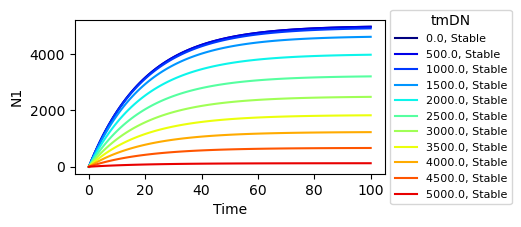

100%|██████████| 500/500 [00:00<00:00, 1466.41it/s]

Minimum distance to intercept: 2.362091416703379
max value: 5000.010156299982


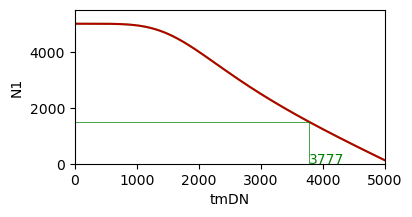

In [1]:
# Code to reproduce example 2.1
from NED_HES_Antimony import NED_runner

runner = NED_runner()

runner.scan(st=100, par2sc='tmDN', rng=(0, 5000), points=11, observe='N1', time2upp=False, legend=True)
runner.scan_bu(par2sc='tmDN', rng=(0, 5000), observe='N1', intercept=1500)

---

### 2.2 DLL4 ($D4$) dynamics: Explanation

$D4$ production is defined by a negative hill function where $D4$ basal production rate ($bD4$) is limited in presence of HES 1 ($H1$, S X), and a scaling parameter $sc$. 

$D4$ degradation is a mass action depndent on current $D4$ plus the $D4$ donated in trans in the previous iteration (calculated in the cell-based simulation in CC3D), and regulated by the parameter $Kdd4$

### 2.2 $D4$ dynamics: Example


Fig 2.2 A: ![D4_tmDN](nb_Figures/D4_tmDN_SC.png) Fig 2.2 B: ![D4_tmDN_stdy](nb_Figures/D4_Stdy_tmDN_SC.png)

Fig 2.2 A: $D4$ production under varying input ($tmDN$ between 0 and 5000). With $tmDN$ = 0 the production rate is maximal platoeing at 5000 units (under default parameter settings, $bD4$ = 1 and $Kdd4$ = 0.05). All timeseries reach half maximal value before step 14 = 14'. With increasing $tmDN$ and corresponding increase in $H1$ (section 2 X), the reaction is strongly inhibited (Fig 2.2 B). Note that, due to the delay in $H1$ processing, the total $D4$ levels start decay significantly after 20-30', indicating that the lateral ihibition signal must be "high" for sufficient time to exert its full effects.

Fig 2.2 B: Steady state values across the $tmDN$ range highlighting the sharp decrease in total cellular $D4$ with $tmDN$ values > ~1600.

In [ ]:
# Code to reproduce example 2.2
from NED_HES_Antimony import NED_runner

runner = NED_runner(autoregulation=False)

runner.scan(st=100, par2sc='tmDN', rng=(0, 5000), points=11, observe='D4', time2upp=False, legend=True)
runner.scan_bu(par2sc='tmDN', rng=(0, 5000), observe='D4', intercept=2200)

---

### 2.3 JAGGED 1 ($J1$) dynamics: Explanation

$J1$ production depends on a basal production rate ($bJ1$ = 0 in default conditions), and it is inducible by HES 1 (proportional to a positive Hill function of $H1$ at a max rate = $VmJ1$).

$J1$ degradation is a mass action dependent on the current $J1$ level and the $J1$ donated in trans in the previous iteration, regulated by the parameter $Kdj1$.

### 2.3 $J1$ dynamics: Example

Fig 2.3 A: ![J1_tmDN](nb_Figures/J1_tmDN_SC.png) Fig 2.3 B: ![J1_tmDN_stdy](nb_Figures/J1_Stdy_tmDN_SC.png)

Fig 2.3 A: $J1$ production under varying input ($tmDN$ between 0 and 5000). With $tmDN$ = 0 the production rate is 0 (under default parameter settings, $bJ1$ = 0 and $Kdj1$ = 0.05). With increasing $tmDN$ and corresponding increase in $H1$ (section 2 X), the reaction is promoted (Fig 2.3 B). Note that, due to the delay in $H1$ processing, the total $J1$ levels start increasing significantly after 20-40' (T 1/2 max for all series 25-40')
, indicating that the lateral ihibition signal must be "high" for sufficient time to exert its full effects.

Fig 2.3 B: Steady state values across the $tmDN$ range highlighting the sharp increase in total cellular $J1$ with $tmDN$ values > ~1600.

In [ ]:
# Code to reproduce example 2.3
from NED_HES_Antimony import NED_runner

runner = NED_runner()

runner.scan(st=100, par2sc='tmDN', rng=(0, 5000), points=11, observe='J1', time2upp=False, legend=True)
runner.scan_bu(par2sc='tmDN', rng=(0, 5000), observe='J1', intercept=1500)

---
---

## S 3: Definition of HES1 dynamics

Within the NED model HES 1 production can be regulated by two alternative sub-models (with or without autoregulatory feedback).
So far we have only used examples without autoregulation. In section  3.2 we will introduce the alternative model with HES autoregulatory feedback.

### 3.1 HES1 ($H1$) dynamics without autoregulation: Explanation

In [6]:
from NED_HES_Antimony import NED_runner
runner = NED_runner()
runner.display_component("HES_no_auto")


        # HES 1 Without autoregulatory feedback
        hMh1=35; 
        Kdh1 = 0.09; bH1 = 0.0; VmH1 = 10;
        H1_prod: =>H1; (bH1 + Hp(VmH1,NICD,hMh1,2)); 
        H1_deg: H1=> ; Ma(H1,Kdh1);
        


In absence of autoregulation, HES 1 ($H1$) production depends on a basal production rate ($bH1$ = 0.0 in default conditions), and it is inducible by $NICD$ (proportional to a positive Hill function of $NICD$ at a max rate = $VmH1$, and K<sub>0.5</sub> = $hMh1$).

$H1$ degradation is a mass action dependent on the current $H1$ level and is regulated by the parameter $Kdh1$.


### 3.1 $H1$ dynamics without autoregulation: Example


*Note*: We scan over the $tmDN$ input parameter (rather than $NICD$) to keep the input constant during the simulation without changing the model string. We omit the study of the $H1_{prod}$, $H1_{deg}$ system in isolation as it closely mirror that of $NICD$ shown in section 1.1. Thus,  the example code, demonstrate the output of the combined system $NI_{prod}$, $NI_{deg}$ and $H1_{prod}$, $H1_{deg}$.

Fig 3.1 A: ![H1_tmDN](nb_Figures/H1_tmDN_SC.png) Fig 3.1 B: ![H1_tmDN_stdy](nb_Figures/H1_Stdy_tmDN_SC.png)

Fig 3.1 A: $H1$ production under varying input ($tmDN$ between 0 and 5000, recall from Ex 1.1 that this yields constant $NICD$ in the 0-100 range). With $tmDN$ = 0 the production rate is 0 (under default parameter settings, $bH1$ = 0 and $Kdh1$ = 0.09). With increasing $tmDN$ and corresponding increase in $NICD$ (section 1), the reaction is promoted (Fig 3.1 B). The delay in $NICD$ processing is minimal, thus the total $H1$ level starts increasing significantly after 9-10' (T 1/2 max for all series 9-10').

Fig 3.1 B: Steady state values across the $tmDN$ range highlighting the sharp increase in total cellular $H1$ with $tmDN$ values > ~1400.

In [ ]:
# Code to reproduce example 2.3
from NED_HES_Antimony import NED_runner

runner = NED_runner()

runner.scan(st=100, par2sc='tmDN', rng=(0, 5000), points=11, observe='H1', time2upp=False, legend=True)
runner.scan_bu(par2sc='tmDN', rng=(0, 5000), observe='H1', intercept=25)

---

### 3.2 $H1$ dynamics with autoregulation: Explanation

In [3]:
from NED_HES_Antimony import NED_runner
runner = NED_runner()
runner.display_component("HES_auto")


        # HES 1 Autoregulation with delay 
        Kni = 0.5; Khe =0.5; 
        kdel = 0.55; kmm = 0.55; hh1 = 8; Mdh = 0.05;
        vm_prna = 1.4; kdh = 0.35;
        
        pmRNA_prod:  => pmRNA; Hc(vm_prna,(NICD*0.01),HES,pmRNA,Kni,1,Khe,hh1,Kni,1); # Competitive hill function for inactive mRNA production
        mRNA_prod: pmRNA => mRNA; MM(pmRNA,kdel,kmm); # Michaelis-Menten for active mRNA production
        pH1_prod: mRNA => pHES; MM(mRNA,kdel,kmm); # Michaelis-Menten for inactive protein production
        HES_prod: pHES => HES; MM(pHES,kdel,kmm); # Michaelis-Menten for active protein production
        HES_deg: HES => ; MM(HES,kdh,Mdh); # Michaelis-Menten for protein degradation

        # Hes scaling
        # H1 = 0
        H1_scaling: => H1; (HES * 100 - H1);
        


### 3.2 Analysis of the HES 1 sub-model dynamics 
To facilitate understanding the HES 1 sytem dynamics we start by studying the sub-model in isolation in the following example.
We rewrite the model string to remove the scaling parameters used to plug the HES 1 sub-model into the NED model. We also write all equations explicitly.

To facilitate the analysis of the HES 1 sub model we have defined a dedicated runner.

#### 3.2 HES 1 sub-model: Explanation

In [1]:
from NED_HES_Antimony import HES_runner
runner = HES_runner()
runner.display_modelstring()


        NICD = 1.0;

        # NOTE: We replace scaled (NICD * 0.01) with NICD
        # Competitive hill function for inactive mRNA transcription        
        vm_prna = 0.09; hh1 = 8; K = 0.5;
        pmRNA_prod:  => pmRNA; vm_prna * NICD/K / (1 + NICD/K + pmRNA/K + HES^hh1/K^hh1);
        
        # Michaelis-Menten reactions for mRNA processing and degradation
        kmrp = 0.1; kmrd = 0.05;
        mRNA_prod: pmRNA => mRNA; kmrp * pmRNA / (K + pmRNA);
        mRNA_deg: mRNA => ; kmrd * mRNA / (K + mRNA); 

        # Michaelis-Menten reactions for protein translation, processing, and degradation
        kphp = 0.1; khp = 0.1; khd = 0.075;
        pHES_prod:  => pHES; kphp * mRNA / (K + mRNA);
        HES_prod: pHES => HES;  khp * pHES / (K + pHES); 
        HES_deg: HES => ; (khd * HES) / (K + HES); 
        


Parameters:

$vm_{prna}$ is the v<sub>max</sub> of the competitive Hill function for the $mRNA_{prod}$ reaction.  
$K$ is the K<sub>0.5</sub> used for both positive and negative regulation, it is possible to chose differnt Ks for each interaction, however in absence of experimental evidence to support specific choice, and to make all interaction dimensionally compatible, we set all Ks equals to 0.5 (K<sub>0.5</sub>). $hh1$ is the Hill (cooperativity) coefficient for HES inhibition. The Hill coefficients for the other regulators are implicitly set to 1. 

$kdel$ is the Vmax of the Michaelis-Menten equations (with Km = $K$) representing the delay in the protein production process.

$kdh$ is the Vmax of the degradation rate equation, a Michaelis-Menten with Km = $K$

---
Reactions:

$pmRNA_{prod}$ : Process the input signal $NICD$ (scaled to 0-1) regulating the production of pre-mRNA. As proposed (ref), the reaction is promoted by NICD but it is negatively regulated by the final product $HES$. Mathematically, to have the HES sub model oscillating as predicted, and experimentally observed in previous studies, we need both autoregulation, and delay in the processing chain. In addition, strong non-linearities ($hh1$ = 8) in the chain, facilitate stable oscillations.

$mRNA_{prod}$, $pHES_{prod}$, $HES_{prod}$ : This chain of reactions introduces a global delay towards the production of the final product (active $HES$). Biologically, the potential surces of delayed protein production are several and a few have been proposed to justify the oscillatory behaviour of the HES system. 

$mRNA_{prod}$ : It has been demonstrated that HES1 mRNA processing is delayed due to long introns-processing.

$mRNA_{deg}$ : For simplicity, we might have chosent to directly chain the mRNA $mRNA_{prod}$ and $pHES_{prod}$, without the need for a $mRNA_{deg}$ law. However, biologically, mRNA is not consumed during protein production, but it is degraded overtime via independent mechanisms.  

$pHES_{prod}$ and $HES_{prod}$: Translation and post translational protein modifications, or nuclear import for TF, are all likely source of delay.

The rate of HES degradation ($HES_{deg}$) is a Michaelis-Menten equation representing rapid degradation of the active protein as previously reported (another precondition to facilitate stable oscillations).

#### 3.2.1 $HES$ dynamics:
We first take a look at how the model responds under the default parameters setting

Fig 3.2.1 A ![HES_NICD](nb_Figures/HES_NICD_SC.png) Fig 3.2.1 B ![HES_NICD_stdy](nb_Figures/HES_Stdy_NICD_SC.png)

We notice that:
- The maximum values for $HES$ increase with increasing input $NICD$ (Fig 3.2.1 A).
- With $NICD$ values < ~ 0.3, the system reaches a stady state production of $HES$.
- With $NICD$ values > ~ 0.3, the system is unstable and  the total $HES$ oscillates (Fig 3.2.1 B).
- The T to reach half maximal values is ~100-120'. a delay which is compatible with previously reported period oscillations of HES protein.

Parameters estimation:
- As the HES sub-model is non dimensional we want its output to scale in the 0-1 range.
- We want stable HES oscillations to occur under at least a fraction of input NICD (range 0-1).
- We want the oscillations to have a period of ~100-120'
- The amplitude of the oscillations has not been strictly defined, however, available experimental and in silico data point at amplitudes covering 70-100% of the whole range.

We want to estimate the model parameters ($vm_{prna}$, $K$, $hh1$, $kmrp$, $kmrd$, $kphp$, $khp$, and $khd$), under these constraints.


100%|██████████| 21/21 [00:02<00:00, 10.48it/s]


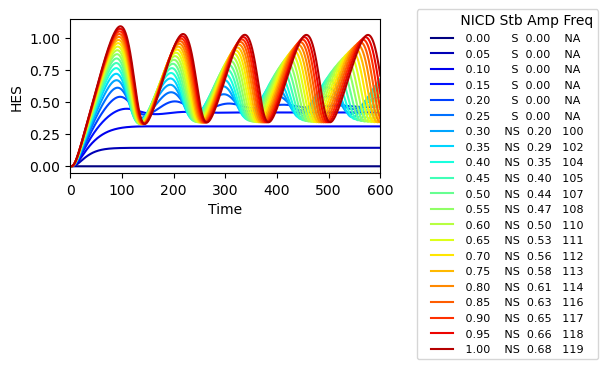

100%|██████████| 500/500 [00:02<00:00, 171.02it/s]


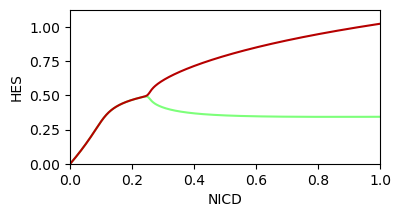

100%|██████████| 100/100 [00:00<00:00, 261.35it/s]


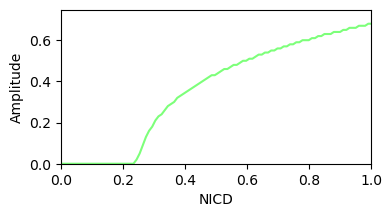

100%|██████████| 100/100 [00:00<00:00, 266.08it/s]


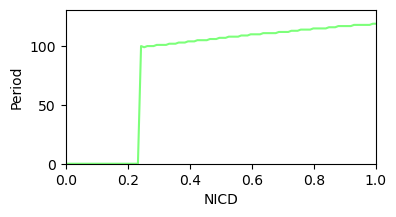

In [1]:
# Code to reproduce example 3.2.1
from NED_HES_Antimony import HES_runner
runner = HES_runner()
runner.scan(st2p=600, par2sc='NICD', rng=(0, 1), points=21, observe='HES', time2upp=False, legend=True)
runner.scan_bu(par2sc='NICD', rng=(0, 1), observe='HES')
runner.scan_ap(par2sc='NICD', rng=(0, 1), observe='HES')
runner.scan_ap(par2sc='NICD', rng=(0, 1), observe='HES',feat='per')

---

#### 3.2.2 SA $vm_{prna}$ Coefficient HES autorgulation

100%|██████████| 11/11 [00:01<00:00, 10.16it/s]


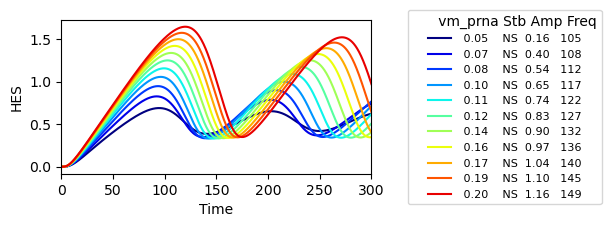

100%|██████████| 500/500 [00:03<00:00, 136.90it/s]


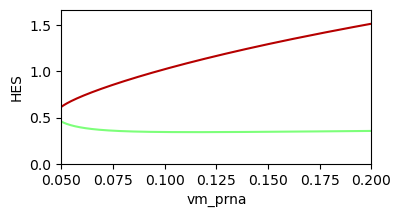

100%|██████████| 100/100 [00:00<00:00, 225.38it/s]


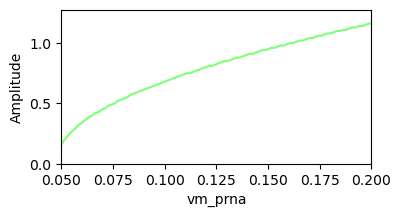

100%|██████████| 100/100 [00:00<00:00, 220.90it/s]


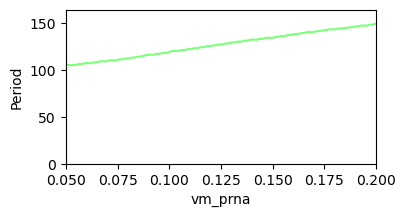

In [4]:
# Code to reproduce example 3.2.1
from NED_HES_Antimony import HES_runner
runner = HES_runner()
runner.scan(st2p=300, par2sc='vm_prna', rng=(0.05, 0.2), points=11, observe='HES', time2upp=False, legend=True)
runner.scan_bu(par2sc='vm_prna', rng=(0.05, 0.2), observe='HES')
runner.scan_ap(par2sc='vm_prna', rng=(0.05, 0.2), observe='HES')
runner.scan_ap(par2sc='vm_prna', rng=(0.05, 0.2), observe='HES',feat='per')

---

#### 3.2.2 SA Hill Coefficient HES autorgulation

100%|██████████| 10/10 [00:00<00:00, 10.25it/s]


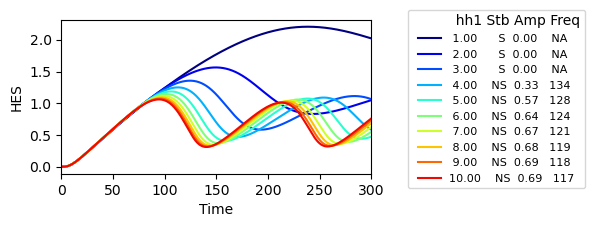

100%|██████████| 500/500 [00:02<00:00, 172.42it/s]


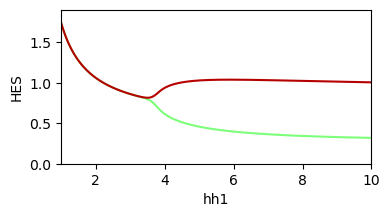

100%|██████████| 100/100 [00:00<00:00, 249.45it/s]


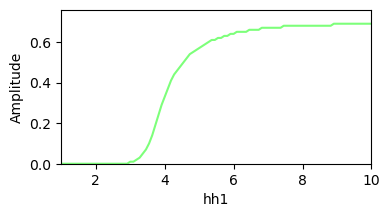

100%|██████████| 100/100 [00:00<00:00, 268.81it/s]


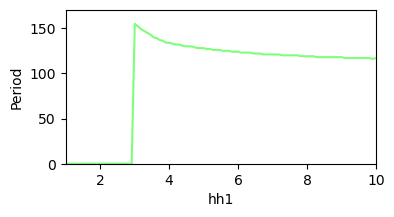

In [5]:
# Code to reproduce example 3.2.2
from NED_HES_Antimony import HES_runner
runner = HES_runner()
runner.scan(st2p=300, par2sc='hh1', rng=(1, 10), points=10, observe='HES', time2upp=False, legend=True)
runner.scan_bu(par2sc='hh1', rng=(1, 10), observe='HES')
runner.scan_ap(par2sc='hh1', rng=(1, 10), observe='HES')
runner.scan_ap(par2sc='hh1', rng=(1, 10), observe='HES',feat='per')

---

#### 3.2.3 SA K HES Autoregulation

100%|██████████| 14/14 [00:01<00:00,  9.99it/s]


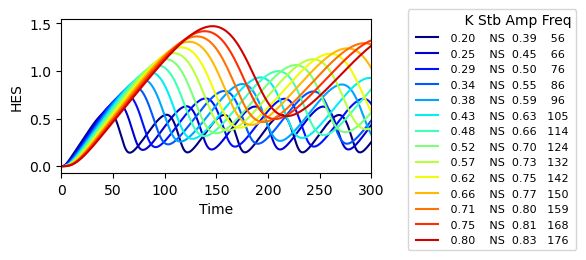

100%|██████████| 500/500 [00:03<00:00, 126.35it/s]


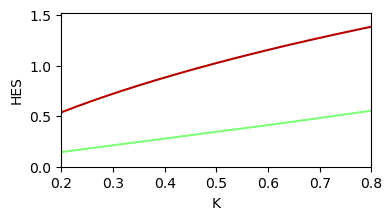

100%|██████████| 100/100 [00:00<00:00, 199.33it/s]


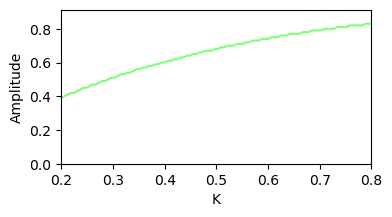

100%|██████████| 100/100 [00:00<00:00, 178.67it/s]


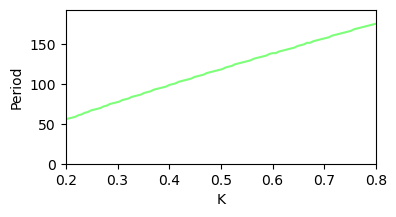

In [6]:
# Code to reproduce example 3.2.3
from NED_HES_Antimony import HES_runner
runner = HES_runner()
runner.NED.NICD = 1.0
runner.scan(st2p=300, par2sc='K', rng=(0.2, 0.8), points=14, observe='HES', time2upp=False, legend=True)
runner.scan_bu(par2sc='K', rng=(0.2, 0.8), observe='HES')
runner.scan_ap(par2sc='K', rng=(0.2, 0.8), observe='HES')
runner.scan_ap(par2sc='K', rng=(0.2, 0.8), observe='HES',feat='per')

---

#### 3.2.3 SA delay in HES production (kmrp)

100%|██████████| 11/11 [00:01<00:00,  9.59it/s]


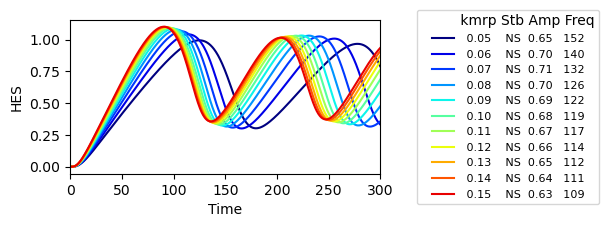

100%|██████████| 500/500 [00:03<00:00, 138.43it/s]


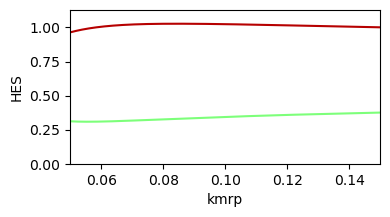

100%|██████████| 100/100 [00:00<00:00, 193.88it/s]


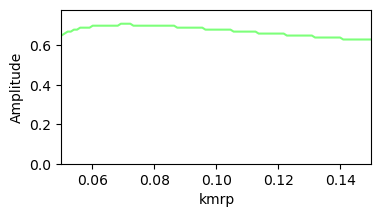

100%|██████████| 100/100 [00:00<00:00, 224.53it/s]


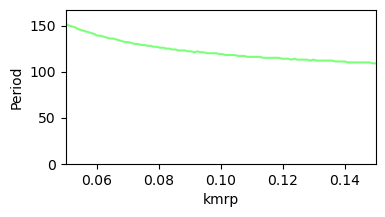

In [7]:
from NED_HES_Antimony import HES_runner
runner = HES_runner()
runner.scan(st2p=300, par2sc='kmrp', rng=(0.05, 0.15), points=11, observe='HES', time2upp=False, legend=True)
runner.scan_bu(par2sc='kmrp', rng=(0.05, 0.15), observe='HES')
runner.scan_ap(par2sc='kmrp', rng=(0.05, 0.15), observe='HES')
runner.scan_ap(par2sc='kmrp', rng=(0.05, 0.15), observe='HES',feat='per')

---

#### 3.2.3 SA delay in HES production (kmrd)

100%|██████████| 16/16 [00:01<00:00, 10.51it/s]


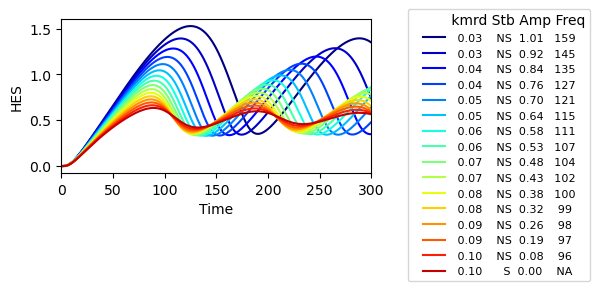

100%|██████████| 500/500 [00:03<00:00, 142.65it/s]


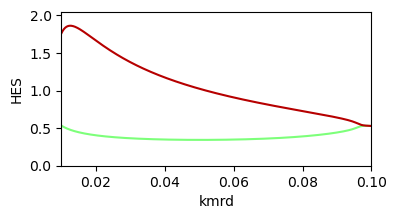

100%|██████████| 100/100 [00:00<00:00, 248.43it/s]


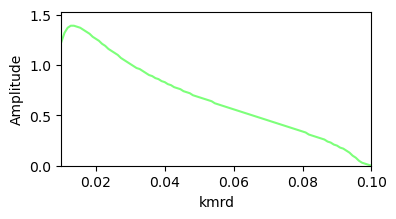

100%|██████████| 100/100 [00:00<00:00, 223.81it/s]


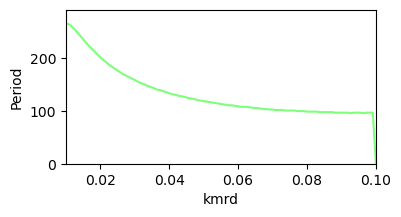

In [8]:
# Code to reproduce example 3.2.3
from NED_HES_Antimony import HES_runner
runner = HES_runner()
runner.NED.NICD = 1.0
runner.scan(st2p=300, par2sc='kmrd', rng=(0.03, 0.1), points=16, observe='HES', time2upp=False, legend=True)
runner.scan_bu(par2sc='kmrd', rng=(0.01, 0.1), observe='HES')
runner.scan_ap(par2sc='kmrd', rng=(0.01, 0.1), observe='HES')
runner.scan_ap(par2sc='kmrd', rng=(0.01, 0.1), observe='HES',feat='per')

#### 3.2.3 SA kmm delay in HES production

100%|██████████| 13/13 [00:01<00:00,  9.81it/s]


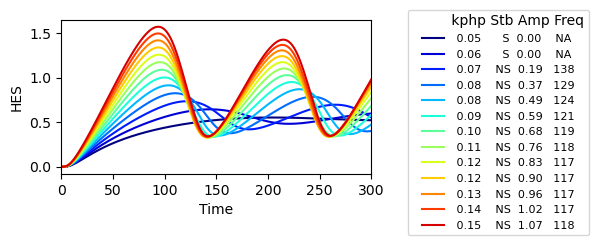

100%|██████████| 500/500 [00:03<00:00, 150.29it/s]


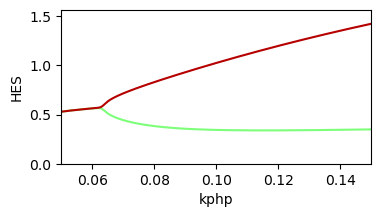

100%|██████████| 100/100 [00:00<00:00, 222.24it/s]


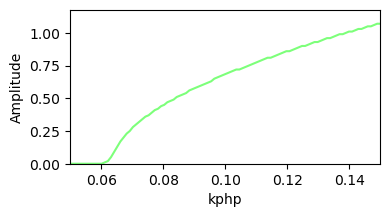

100%|██████████| 100/100 [00:00<00:00, 231.47it/s]


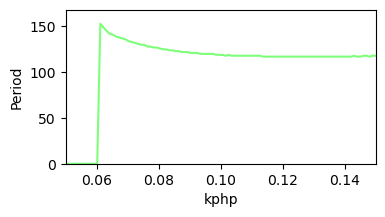

In [9]:
from NED_HES_Antimony import HES_runner
runner = HES_runner()
runner.scan(st2p=300, par2sc='kphp', rng=(0.05, 0.15), points=13, observe='HES', time2upp=False, legend=True)
runner.scan_bu(par2sc='kphp', rng=(0.05, 0.15), observe='HES')
runner.scan_ap(par2sc='kphp', rng=(0.05, 0.15), observe='HES')
runner.scan_ap(par2sc='kphp', rng=(0.05, 0.15), observe='HES',feat='per')

#### 3.2.3 SA khp HES degradation

100%|██████████| 21/21 [00:02<00:00,  9.83it/s]


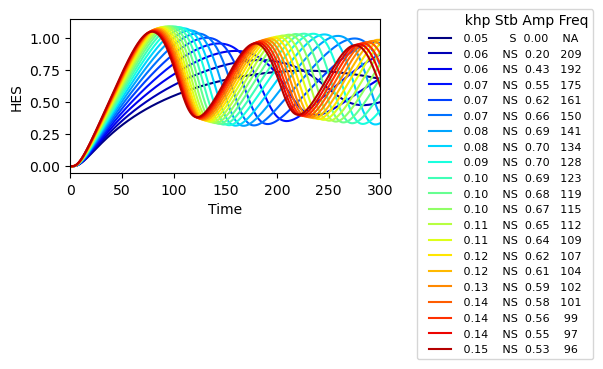

100%|██████████| 500/500 [00:03<00:00, 142.68it/s]


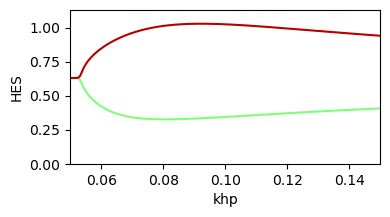

100%|██████████| 100/100 [00:00<00:00, 230.46it/s]


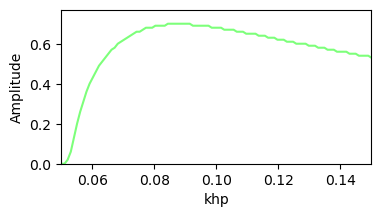

100%|██████████| 100/100 [00:00<00:00, 237.51it/s]


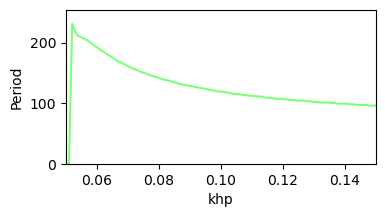

In [10]:
runner = HES_runner()
runner.scan(st2p=300, par2sc='khp', rng=(0.05, 0.15), points=21, observe='HES', time2upp=False, legend=True)
runner.scan_bu(par2sc='khp', rng=(0.05, 0.15), observe='HES')
runner.scan_ap(par2sc='khp', rng=(0.05, 0.15), observe='HES')
runner.scan_ap(par2sc='khp', rng=(0.05, 0.15), observe='HES',feat='per')

#### 3.2.3 SA khd HES degradation

100%|██████████| 21/21 [00:02<00:00, 10.43it/s]


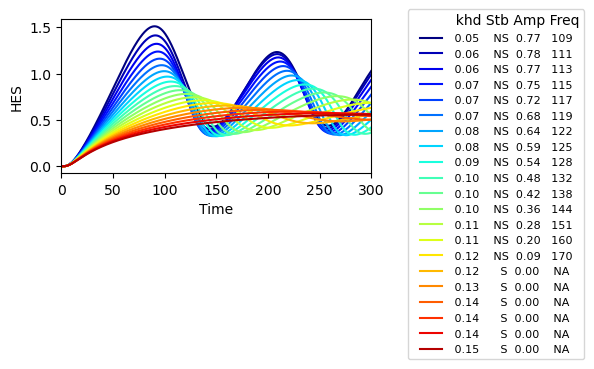

100%|██████████| 500/500 [00:02<00:00, 175.35it/s]


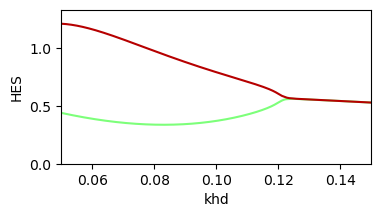

100%|██████████| 100/100 [00:00<00:00, 256.02it/s]


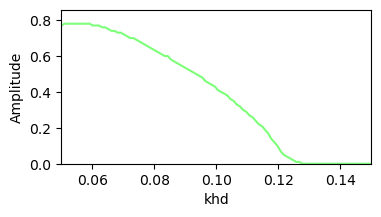

100%|██████████| 100/100 [00:00<00:00, 283.66it/s]


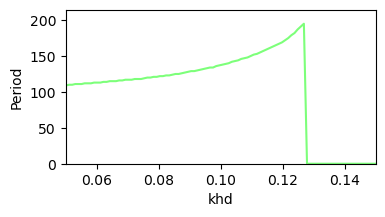

In [11]:
runner = HES_runner()
runner.NED.NICD = 1
runner.scan(st2p=300, par2sc='khd', rng=(0.05, 0.15), points=21, observe='HES', time2upp=False, legend=True)
runner.scan_bu(par2sc='khd', rng=(0.05, 0.15), observe='HES')
runner.scan_ap(par2sc='khd', rng=(0.05, 0.15), observe='HES')
runner.scan_ap(par2sc='khd', rng=(0.05, 0.15), observe='HES',feat='per')

3.2.4 Phase protraits

100%|██████████| 1600/1600 [05:56<00:00,  4.49it/s]


<Figure size 400x400 with 0 Axes>

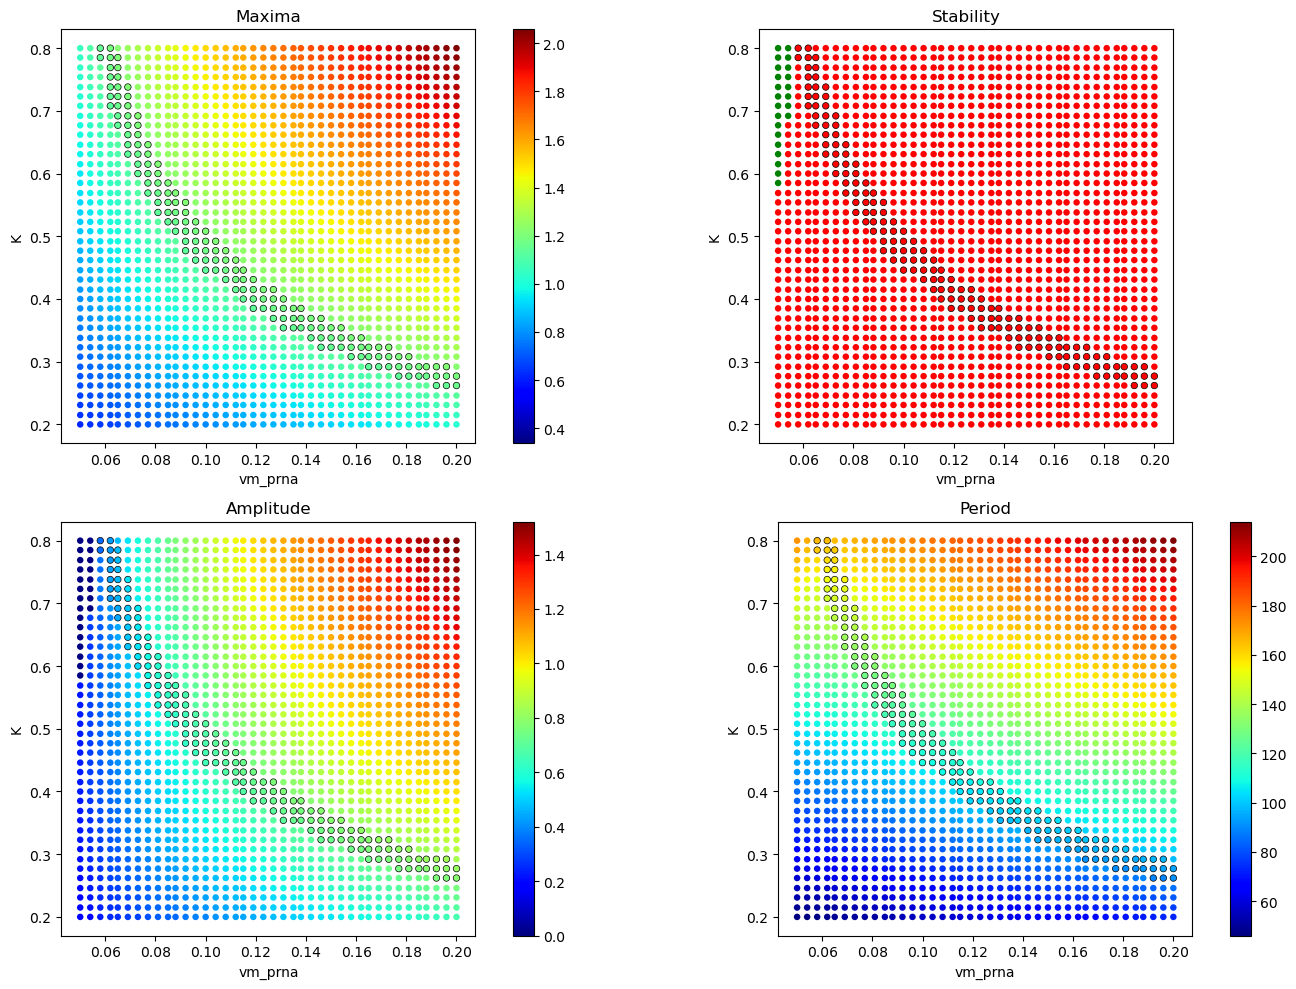

In [1]:
from NED_HES_Antimony import HES_runner
runner = HES_runner()
# NOTE: Default NICD = 1.0
runner.phase_portrait_parallel('vm_prna', 'K', (0.05, 0.2), (0.2, 0.8), 'HES', 
                               num_cpus=14, points=40, target=1)

100%|██████████| 1600/1600 [06:28<00:00,  4.12it/s]


<Figure size 400x400 with 0 Axes>

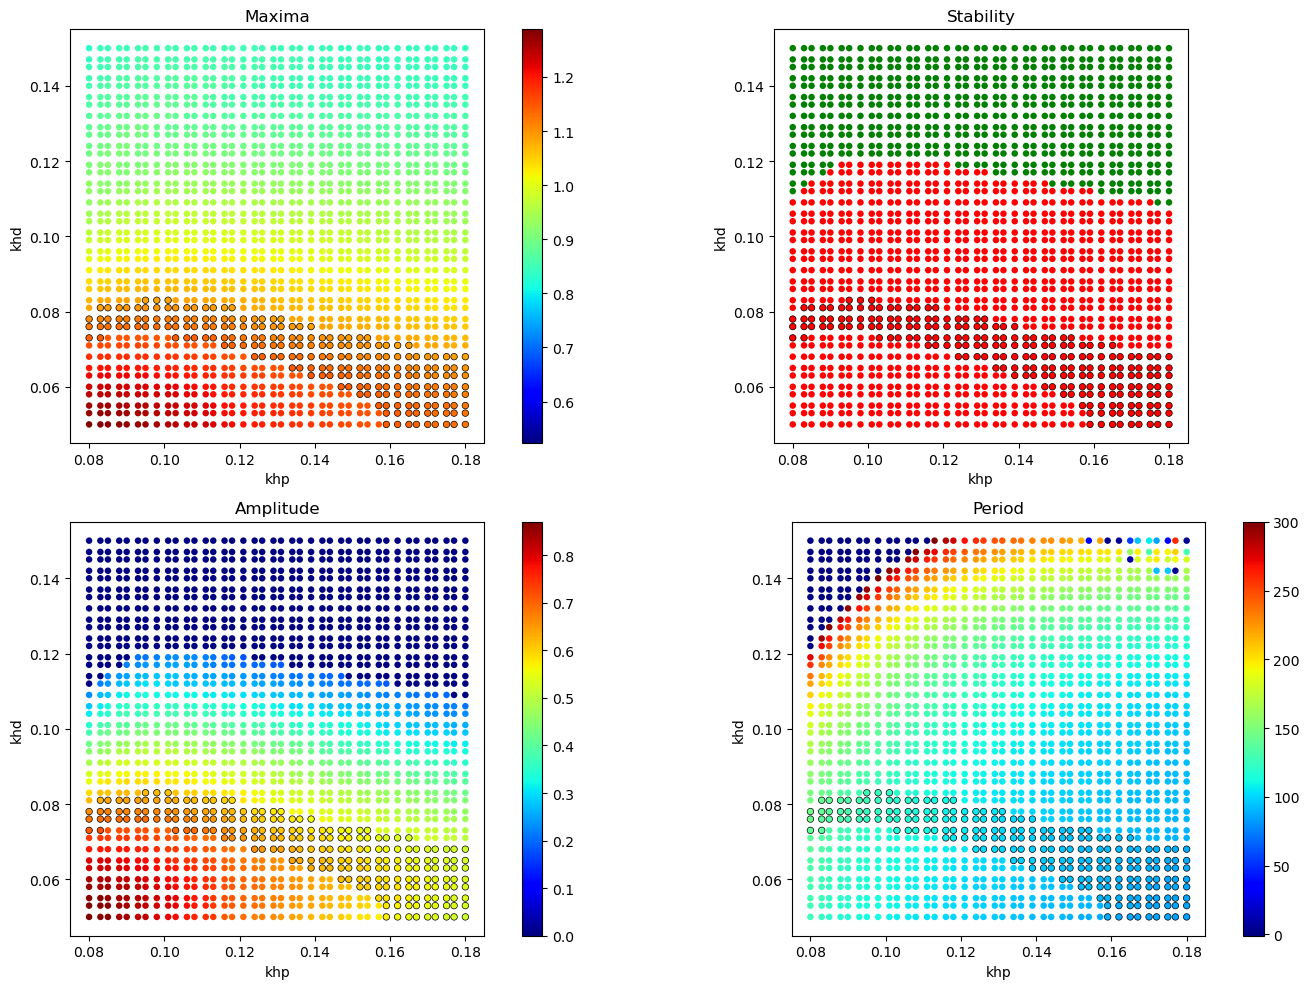

In [12]:
from NED_HES_Antimony import HES_runner
runner = HES_runner()
# NOTE: Default NICD = 1.0
runner.phase_portrait_parallel('khp', 'khd', (0.08, 0.18), (0.05, 0.15), 'HES', 
                               num_cpus=14, points=40, target=1)

100%|██████████| 1600/1600 [06:40<00:00,  4.00it/s]


<Figure size 400x400 with 0 Axes>

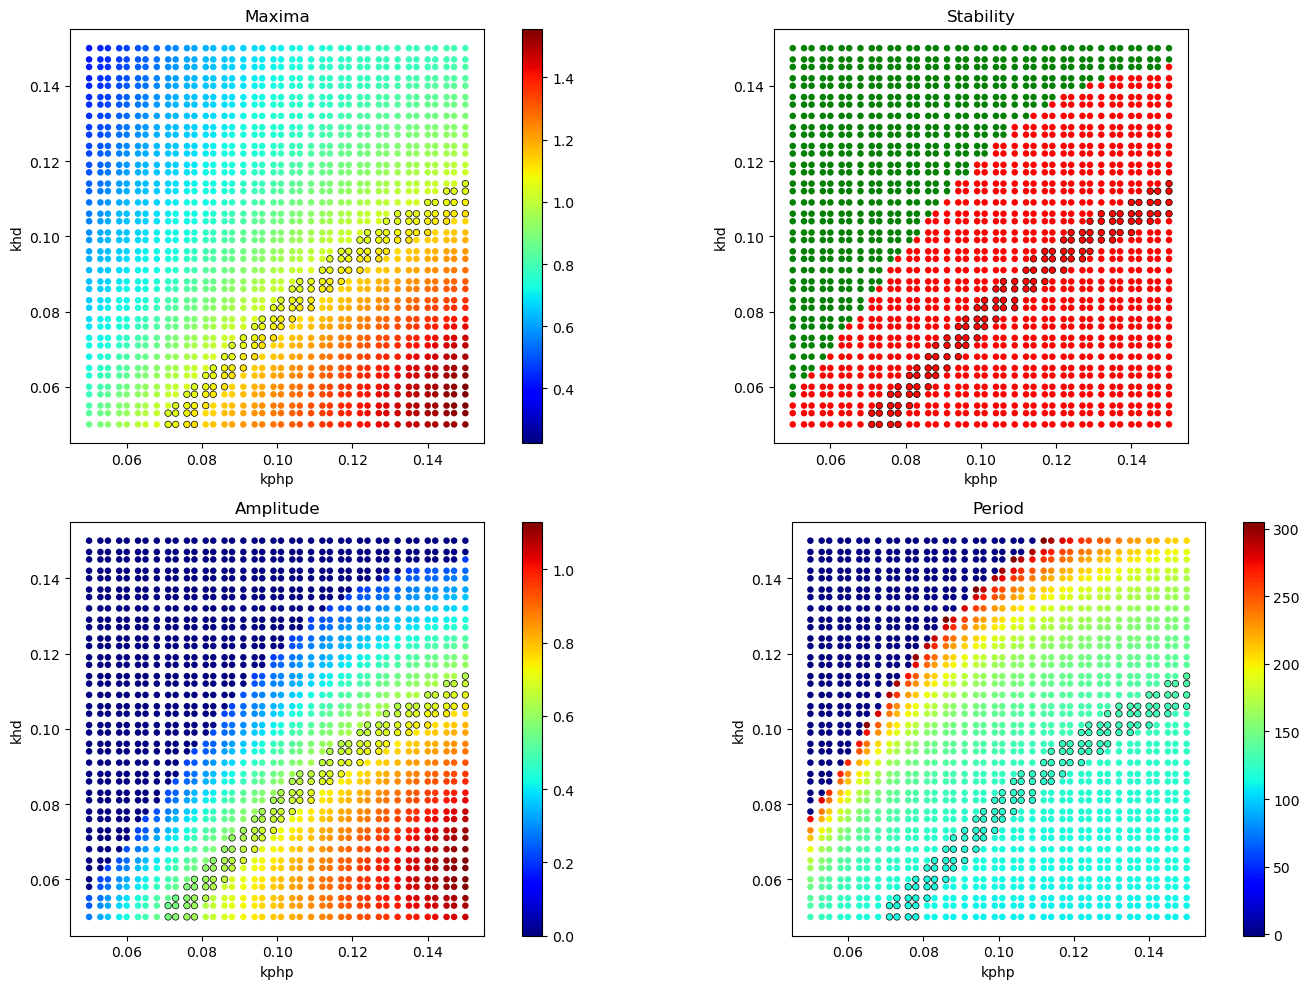

In [ ]:
from NED_HES_Antimony import HES_runner
runner = HES_runner()
# NOTE: Default NICD = 1.0
runner.phase_portrait_parallel('kphp', 'khd', (0.05, 0.15), (0.05, 0.15), 'HES', 
                               num_cpus=14, points=40, target=1)

100%|██████████| 1600/1600 [04:37<00:00,  5.77it/s]


<Figure size 400x400 with 0 Axes>

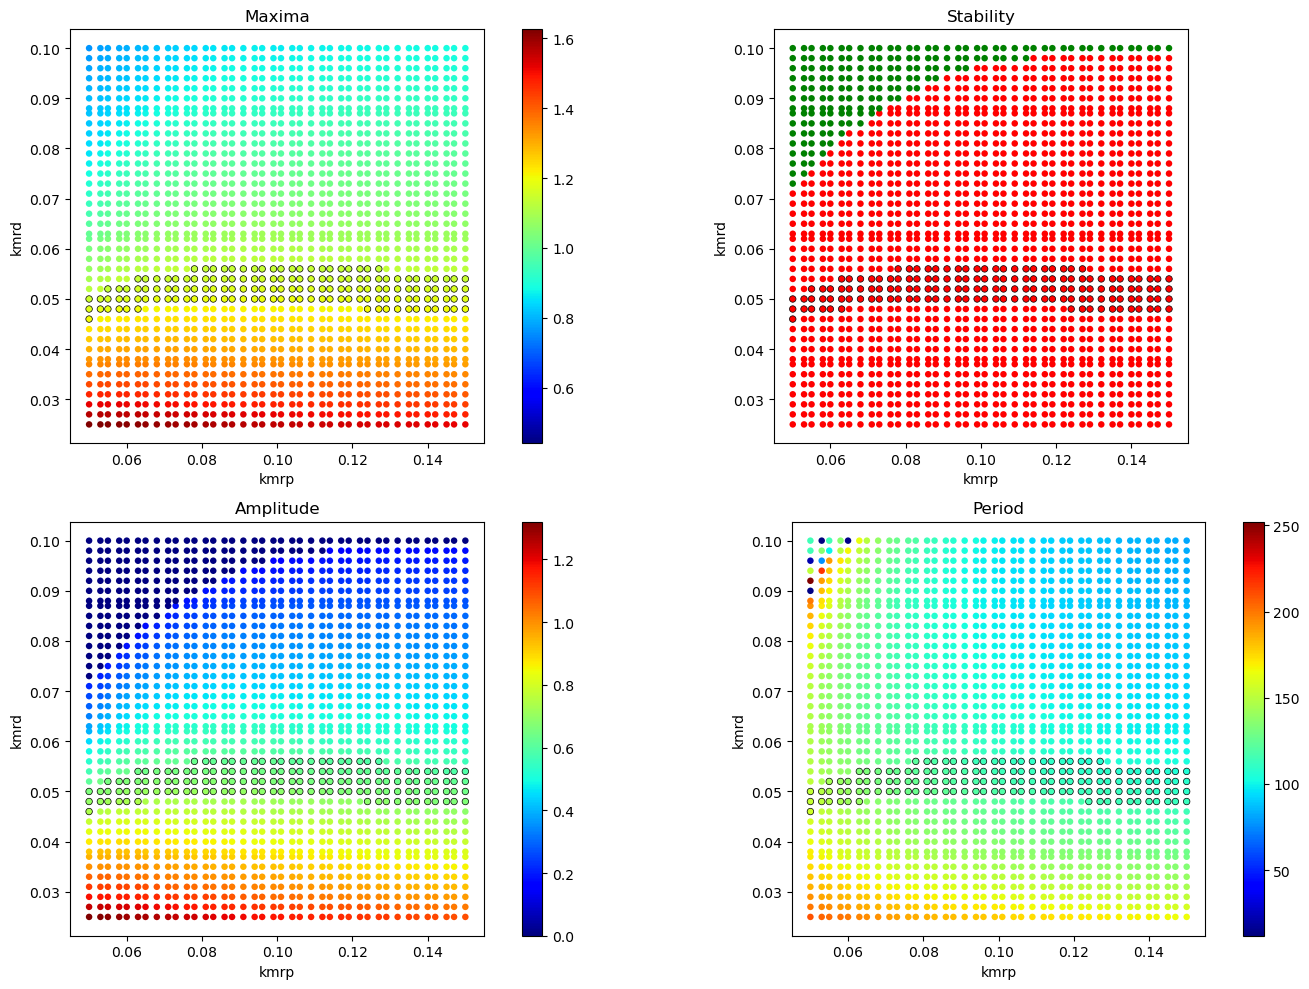

In [13]:
from NED_HES_Antimony import HES_runner
runner = HES_runner()
# NOTE: Default NICD = 1.0
runner.phase_portrait_parallel('kmrp', 'kmrd', (0.05, 0.15), (0.025, 0.1), 'HES', 
                               num_cpus=14, points=40, target=1)


100%|██████████| 900/900 [05:45<00:00,  2.61it/s]


<Figure size 400x400 with 0 Axes>

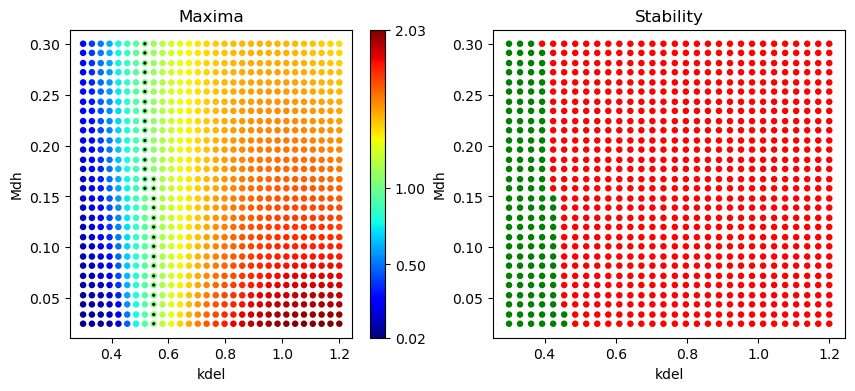

In [3]:
from NED_HES_Antimony import HES_runner
runner = HES_runner()
# NOTE: Default NICD = 1.0
runner.phase_portrait_parallel('kdel', 'Mdh', (0.3, 1.2), (0.025, 0.3), 'HES',14,30)

100%|██████████| 900/900 [05:40<00:00,  2.65it/s]


<Figure size 400x400 with 0 Axes>

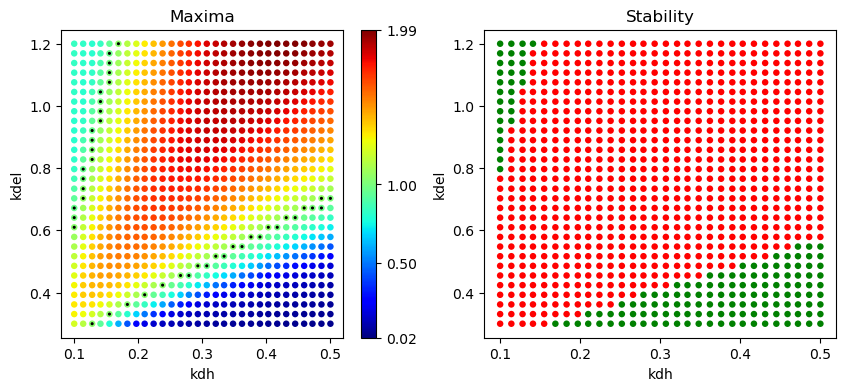

In [5]:
from NED_HES_Antimony import HES_runner
runner = HES_runner()

runner.phase_portrait_parallel('kdh', 'kdel', (0.1, 0.5), (0.3, 1.2), 'HES',14,30)